In [344]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=450000)

## DROP

In [345]:
drop_columns = ['socialEngagementType','totals_bounces', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

## 전처리
### str 변환 함수

In [346]:
# def transform_str (df:pd.DataFrame)-> pd.DataFrame:
#     """
#         str 형태로 변환하는 함수
#     """
#     transform_str_columns = ['fullVisitorId']
#     df[transform_str_columns]=df[transform_str_columns].astype(str)
#     return df

# transform_str(df)
# df.info()

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [347]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_newVisits']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= np.int64(df[transform_int_columns])
    return df 
    
df=change_numeric(df)


### 날짜형 데이터로 변환

In [348]:
df['date'] =pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

df['hour_of_day'] = df['visitStartTime'].dt.hour
df['date_of_weekday']=df.visitStartTime.dt.dayofweek
df['date_of_weekday']= df.groupby(df['date_of_weekday'])['fullVisitorId'].nunique()
df['date_of_weekday']=df['date_of_weekday'].dropna()
df['date_of_Month'] = df['visitStartTime'].dt.strftime('%y-%m')



In [349]:
df['totals_transactionRevenue']=pd.to_numeric(df['totals_transactionRevenue'])
df['totals_transactionRevenue'] = (df['totals_transactionRevenue']**(1/6)).round(2)

### 첫 방문자와 재 방문자의 비율

In [350]:
first_session = df[df.visitNumber == 1]['visitNumber'].count()
returning_session_ratio  = df[df.visitNumber != 1]['visitNumber'].count()

session_count= df.visitNumber.count()

first_session_ratio = (first_session/session_count * 100)
display(f"첫 방문자의 비율: {first_session_ratio:.2f}%")

returning_session_ratio  = (returning_session_ratio /session_count * 100)
display(f"재방문자의 비율: {returning_session_ratio :.2f}%")

첫 방문자의 비율: 78.00%
재방문자의 비율: 22.00%


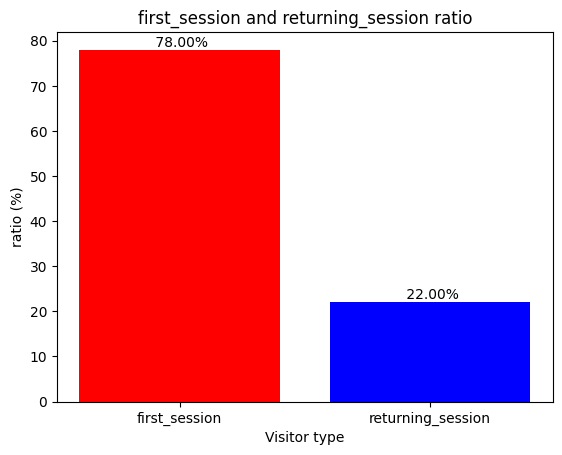

In [351]:
labels = ['first_session', 'returning_session']
ratios = [first_session_ratio, returning_session_ratio]

plt.bar(labels, ratios, color=['red', 'blue'])


plt.title('first_session and returning_session ratio')
plt.xlabel('Visitor type')
plt.ylabel('ratio (%)')
plt.text(0, ratios[0]+0.7, f'{ratios[0]: .2f}%', ha='center')
plt.text(1, ratios[1]+0.7, f'{ratios[1]: .2f}%', ha='center')

# 그래프 출력
plt.show()

## 채널별 효과 분석 (재혁)
    - 캠페인으로 들어온 사람은 다른 사람과 다른 특징을 가지고 있는지 분석
    - 매출이 우수한 채널이 있는지

### 시간대 별 추이

캠페인에 참여한 사람들은 11시에 접속수가 가장 적고, 3,15,18,20시가 가장 많은 접속이 이루어지는걸 볼 수 있음.

캠페인 참여 안한 사람들은 5시에 최저, 17,18시가 가장 많은 접속 했음을 알 수 있고,  캠페인에 참여하지 않은 사람들은 주로 오후에 활동하는것으로 판단된다.

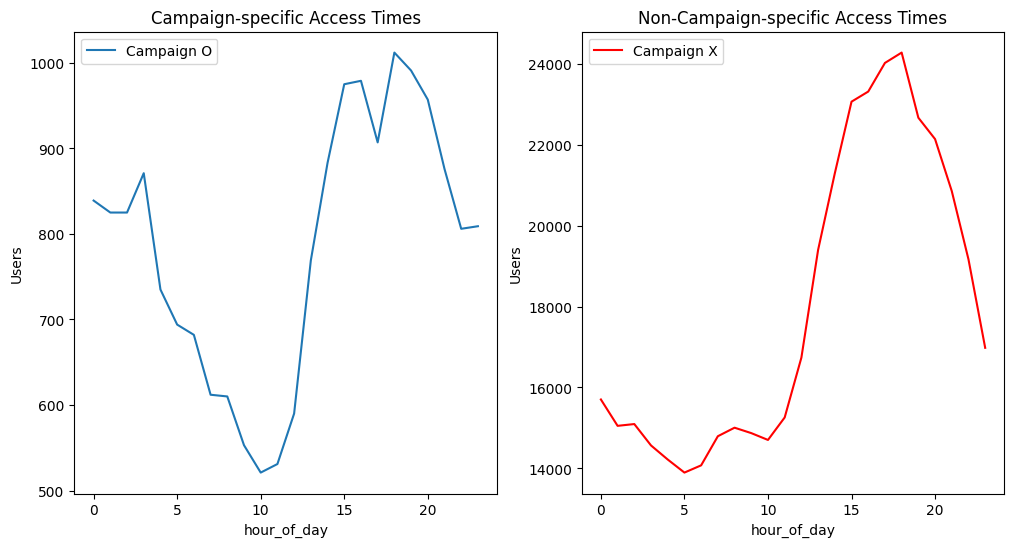

In [352]:
#캠페인에 따른 시간대 별 차이
df_set=df.loc[df['trafficSource_campaign'] != '(not set)']
df_not_set=df.loc[df['trafficSource_campaign'] == '(not set)']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',label='Campaign O')
plt.title('Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

plt.subplot(1,2,2)
df_not_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',color='red',label='Campaign X')
plt.title('Non-Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

### 월별 추이 

- 공통점 :  16년 11월에 접속을 많이했다. 

 - 차이점 :  16년 11월 이후 떨어지는 추세였다가 반등하여 17년 6월에 캠페인으로 들어온 사람들은 고점을 기록
   - 17년 6월에 어떤 일이 있었기에 그들이 많이 방문했는가?   
   - 접속자 수를 보면 16년 11월, 17년 6월에 많은 매출이 나올 것이다.

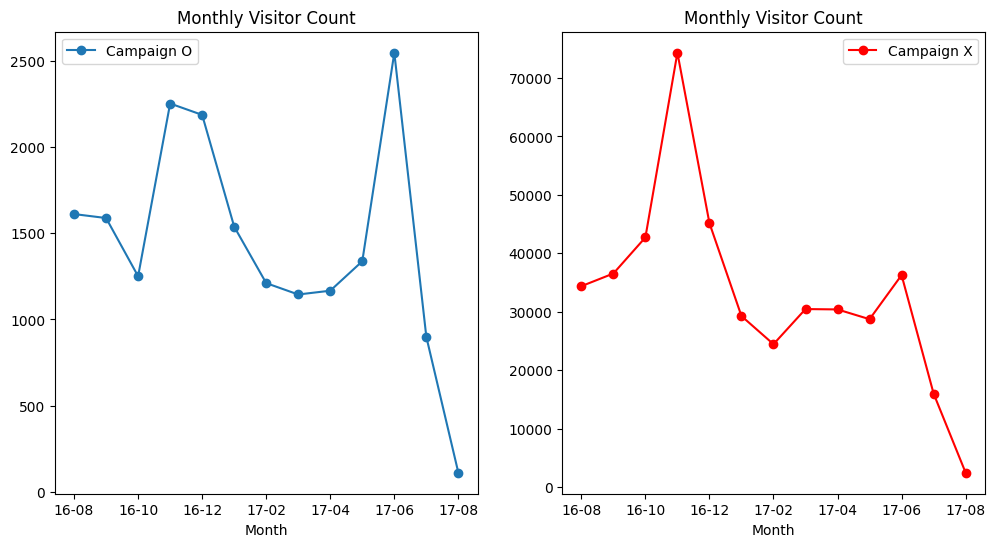

In [353]:
# 캠페인 별 접속한 월 추이
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['date_of_Month'].value_counts().sort_index().plot(kind='line',label='Campaign O', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.legend()

plt.subplot(1,2,2)
df_not_set['date_of_Month'].value_counts().sort_index().plot(kind='line',color='red',label='Campaign X', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.legend()


### 캠페인 별 매출 추이 
   - 캠페인으로 들어온 사람들은 17년 6월에 가장 많은 접속자를 기록했는데 매출은 두번째로 많이 접속했던 16년 11월이 1등을 기록
     - 왜? 17년 6월에는 접속자 수 대비 매출(거래 수익)이 줄었는가?

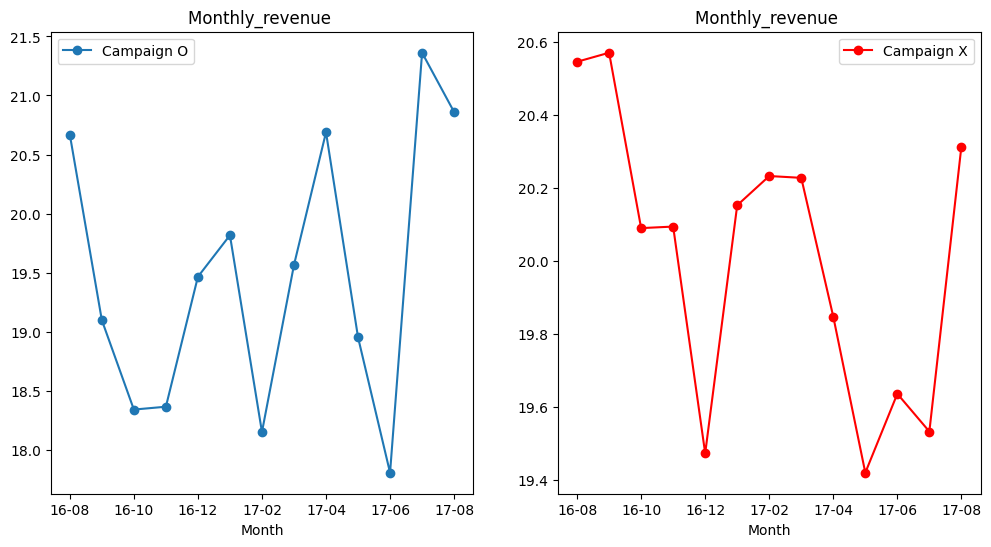

In [366]:
#캠페인 별 매출 추이
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
df_set.groupby('date_of_Month')['totals_transactionRevenue'].mean().plot(kind='line',label='Campaign O' ,marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.legend()


plt.subplot(1,2,2)
df_not_set.groupby('date_of_Month')['totals_transactionRevenue'].mean().plot(kind='line',label='Campaign X',color='red', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.legend()

### 캠페인 여부에 따른 검색 유형

- 캠패인에 참여 안한 사람들은 40%는 Organic( 검색엔진에 키워드를 통해 웹사이트에 유입)

  - 27%의 사람들은 Social을 통한 유입, 14%는 Direct로 유입,  0.3%의 사람들이 Paid Search(유료 광고 )로 유입

-  캠페인에 참여한 사람들은 55% 사람들은Paid Search(유료 검색)으로 들어옴.
 
   - 44%의 사람들이 Affiliates(제휴 | 계열사) 로 들어옴.

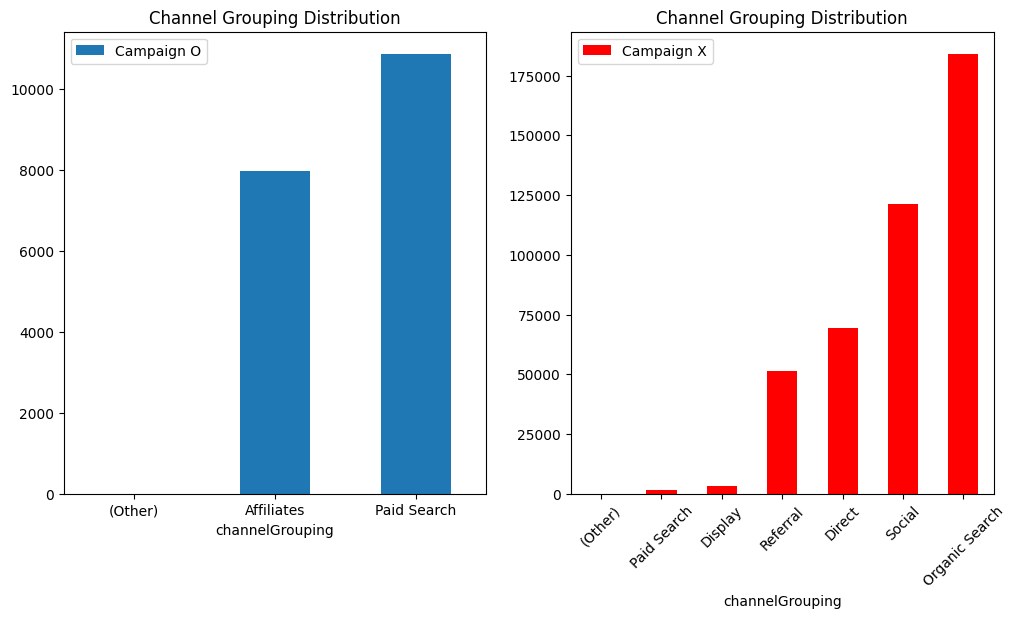

In [355]:
# 켐페인 별 검색 유형  
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',label='Campaign O')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation = 0)
plt.legend()


plt.subplot(1,2,2)
df_not_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',color='red', label='Campaign X')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation=45)
plt.legend()

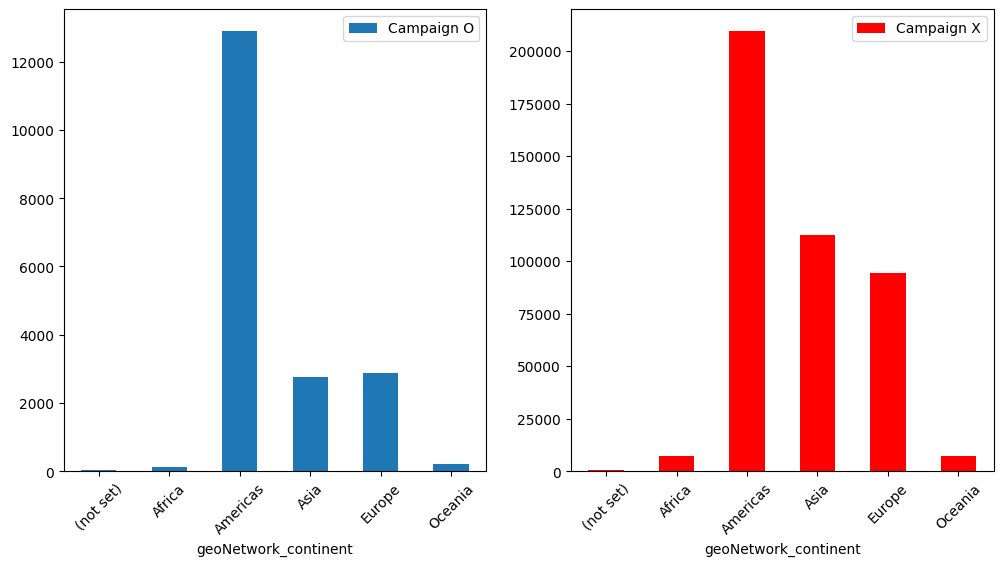

In [356]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',label='Campaign O')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1,2,2)
df_not_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',color='red',label='Campaign X')
plt.xticks(rotation=45)
plt.legend()

### 캠페인 별 유입 소스 차이
2개의 그래프 모두 다 Google이 1등을 차지 했지만
캠페인에 참여한 사람들은 Partners를 통해 많이 들어온다.  ->> 검색 유형에서도 알 수 있듯이 Affiliates와 연관이 있을 것이라고 생각

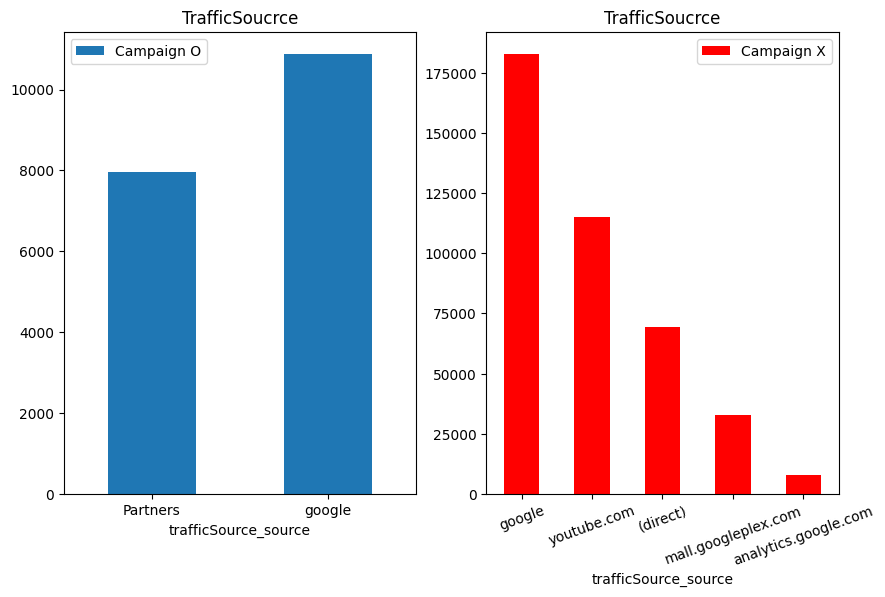

In [357]:
#캠페인 별 유입 소스 차이
top5_source=df_not_set['trafficSource_source'].value_counts().nlargest(n=5)
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
df_set['trafficSource_source'].value_counts().sort_index().plot(kind='bar',label='Campaign O')
plt.title('TrafficSoucrce')
plt.xticks(rotation=0)
plt.legend()

plt.subplot(1,2,2)
top5_source.plot(kind='bar',label='Campaign X',color='red')
plt.title('TrafficSoucrce')
plt.xticks(rotation = 20)
plt.legend()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '16-08'),
  Text(1, 0, '16-09'),
  Text(2, 0, '16-10'),
  Text(3, 0, '16-11'),
  Text(4, 0, '16-12'),
  Text(5, 0, '17-01'),
  Text(6, 0, '17-02'),
  Text(7, 0, '17-03'),
  Text(8, 0, '17-04'),
  Text(9, 0, '17-05'),
  Text(10, 0, '17-06'),
  Text(11, 0, '17-07'),
  Text(12, 0, '17-08')])

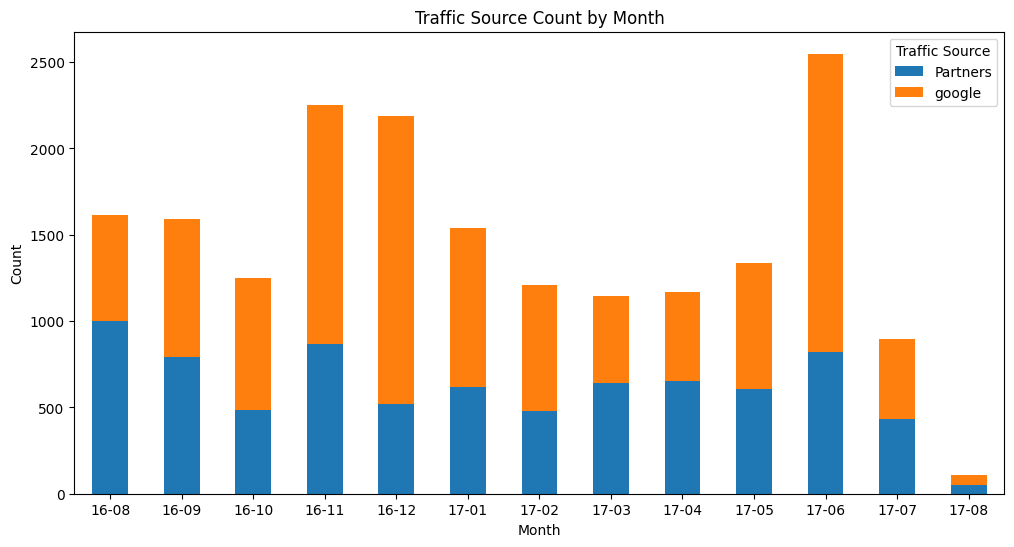

In [358]:

df_set_Month_traffic=df_set.groupby('date_of_Month')['trafficSource_source'].value_counts().unstack(fill_value=0)
df_set_Month_traffic.plot(kind='bar',stacked=True,figsize=(12,6))
plt.title('Traffic Source Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Traffic Source')
plt.xticks(rotation=0) 


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(16-11, youtube.com)'),
  Text(1, 0, '(17-06, google)'),
  Text(2, 0, '(16-11, google)'),
  Text(3, 0, '(16-10, youtube.com)'),
  Text(4, 0, '(16-12, google)')])

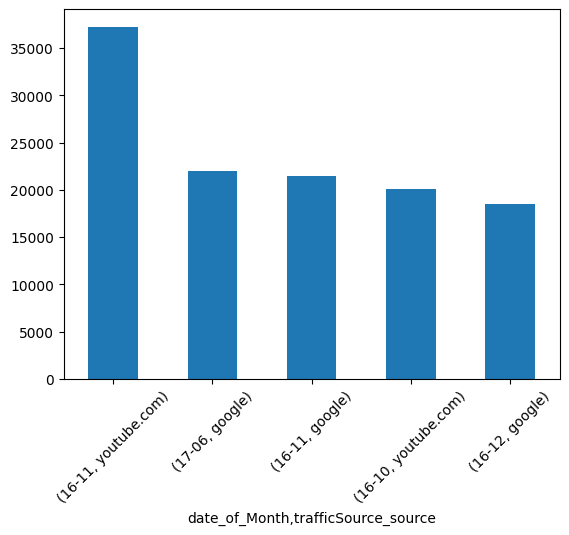

In [359]:
df_not_set.groupby('date_of_Month')['trafficSource_source'].value_counts().nlargest(n=5).plot(kind='bar')
plt.xticks(rotation=45)

In [360]:
# 시간대별로 채널 그룹의 빈도를 계산한 df
# reset_index로 count컬럼을 분리
# apply로 largest를 각 행(count컬럼)마다 적용해서 상위 3개 추출, drop=true로 덮어쓰기 
channel_grouping_counts = df_not_set.groupby(['hour_of_day', 'channelGrouping']).size().reset_index(name='count')
top_3_channels = channel_grouping_counts.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

display(top_3_channels[top_3_channels.hour_of_day == 19])
display(top_3_channels[top_3_channels.hour_of_day == 15])


channel_grouping_counts_set = df_set.groupby(['hour_of_day', 'channelGrouping']).size().reset_index(name='count')
top_2_channels_set = channel_grouping_counts_set.groupby('hour_of_day').apply(lambda x: x.nlargest(2, 'count')).reset_index(drop=True)


display(top_2_channels_set[top_2_channels_set.hour_of_day == 19])
display(top_2_channels_set[top_2_channels_set.hour_of_day == 15])

C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3951674826.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_channels = channel_grouping_counts.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)


,hour_of_day,channelGrouping,count
57,19,Organic Search,9852
58,19,Social,5123
59,19,Direct,3835


,hour_of_day,channelGrouping,count
45,15,Organic Search,9965
46,15,Social,6257
47,15,Direct,3869


C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3951674826.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_2_channels_set = channel_grouping_counts_set.groupby('hour_of_day').apply(lambda x: x.nlargest(2, 'count')).reset_index(drop=True)


,hour_of_day,channelGrouping,count
38,19,Paid Search,694
39,19,Affiliates,297


,hour_of_day,channelGrouping,count
30,15,Paid Search,552
31,15,Affiliates,423


### 시간대 별 트래픽 소스
- 캠페인으로 들어온 사람들은 보통 Paid Search를 통해 들어온다.  이를 많이 늘리기 위해서는  google과 youtube의 홍보를 많이 하여 Paid Search의 비율을 늘린다.\
그러면 왜 늘리는거지?  늘리면 뭐가 좋지? 많이 돈을 쓰는것도 아니고


In [361]:
# 시간대 별  트래픽 소스

Continent_hour= df_not_set.groupby(['hour_of_day', 'trafficSource_source']).size().reset_index(name='count')
top_3_Continent = Continent_hour.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

display(top_3_Continent[top_3_Continent.hour_of_day == 19])
display(top_3_Continent[top_3_Continent.hour_of_day == 15])


Continent_hour_set= df_set.groupby(['hour_of_day', 'trafficSource_source']).size().reset_index(name='count')
top_3_Continent_set = Continent_hour_set.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

display(top_3_Continent_set[top_3_Continent_set.hour_of_day == 19])
display(top_3_Continent_set[top_3_Continent_set.hour_of_day == 15])


C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3767396951.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_Continent = Continent_hour.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)


,hour_of_day,trafficSource_source,count
57,19,google,9835
58,19,youtube.com,4829
59,19,(direct),3835


,hour_of_day,trafficSource_source,count
45,15,google,9870
46,15,youtube.com,5944
47,15,(direct),3869


C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3767396951.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_Continent_set = Continent_hour_set.groupby('hour_of_day').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)


,hour_of_day,trafficSource_source,count
38,19,google,694
39,19,Partners,297


,hour_of_day,trafficSource_source,count
30,15,google,552
31,15,Partners,423


### 캠페인에 따른 chnnel별 페이지 수 

C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3429967912.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.85,set_counts[1]+100,set_counts[1])
C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3429967912.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(1.85,set_counts[2]+100,set_counts[2])
C:\Users\kwon8\AppData\Local\Temp\ipykernel_4868\3429967912.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt

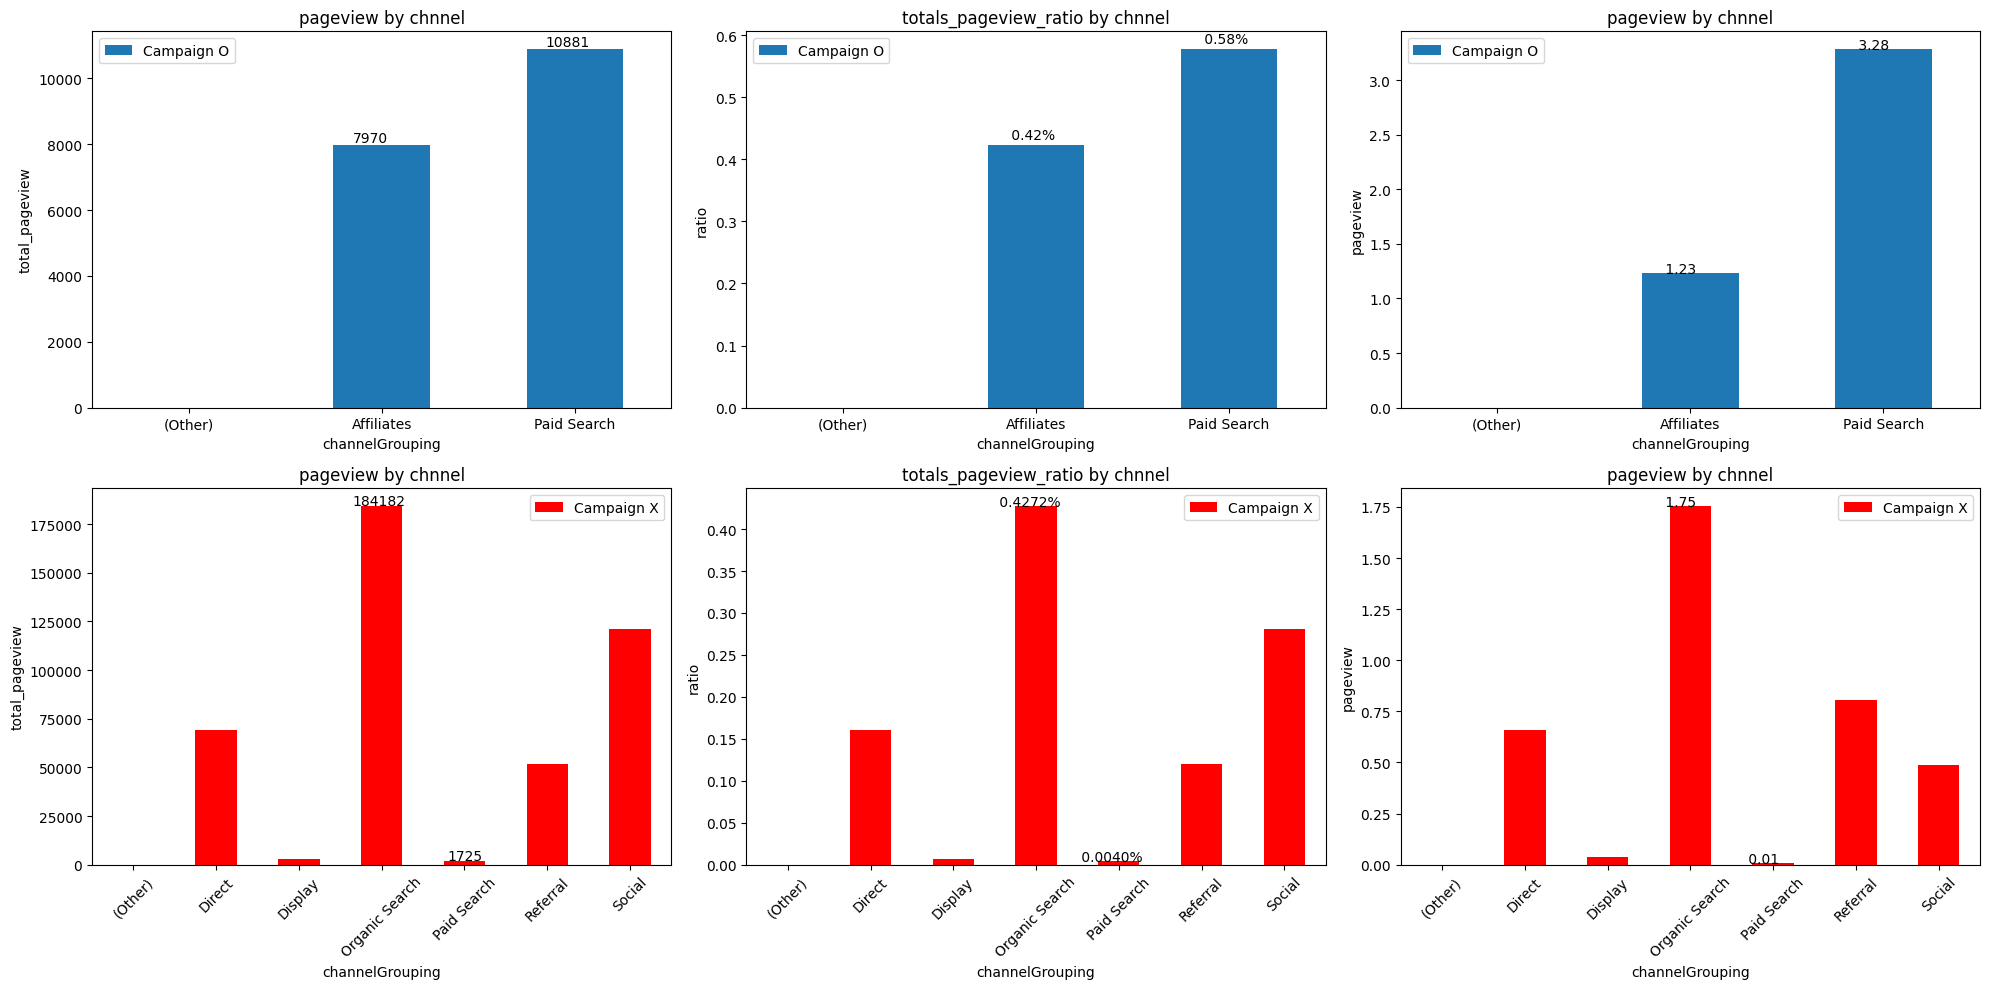

In [362]:
set_counts=df_set.groupby('channelGrouping')['totals_pageviews'].count()
total_set_counts=df_set['totals_pageviews'].count()
pageviews_ratio_set = set_counts / total_set_counts

totals_page_revenue=df_set.groupby('channelGrouping')['totals_pageviews'].sum()
revenue_per_pagecount=totals_page_revenue/total_set_counts


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
set_counts.plot(kind='bar',label='Campaign O')
plt.xticks(rotation=0)
plt.text(0.85,set_counts[1]+100,set_counts[1])
plt.text(1.85,set_counts[2]+100,set_counts[2])
plt.title('pageview by chnnel')
plt.ylabel('total_pageview')
plt.legend()

plt.subplot(2,3,2)
pageviews_ratio_set.plot(kind='bar',label='Campaign O')
plt.xticks(rotation=0)
plt.text(0.85,pageviews_ratio_set[1]+0.01, f'{pageviews_ratio_set[1] : .2f}%')
plt.text(1.85,pageviews_ratio_set[2]+0.01,f'{pageviews_ratio_set[2] : .2f}%')
plt.title('totals_pageview_ratio by chnnel')
plt.ylabel('ratio')
plt.legend()

plt.subplot(2,3,3)
revenue_per_pagecount.plot(kind='bar',label='Campaign O')
plt.xticks(rotation=0)
plt.text(0.85,revenue_per_pagecount[1], f'{revenue_per_pagecount[1] : .2f}')
plt.text(1.85,revenue_per_pagecount[2],f'{revenue_per_pagecount[2] : .2f}')
plt.title('pageview by chnnel')
plt.ylabel('pageview')
plt.legend()

not_set_counts=df_not_set.groupby('channelGrouping')['totals_pageviews'].count()
total_not_set_counts=df_not_set['totals_pageviews'].count()
pageviews_ratio_not_set = not_set_counts / total_not_set_counts

totals_page_revenue_notset=df_not_set.groupby('channelGrouping')['totals_pageviews'].sum()
chnnel_per_pagecount_notset=totals_page_revenue_notset/total_not_set_counts



plt.subplot(2,3,4)
not_set_counts.plot(kind='bar',color='red',label='Campaign X')
plt.xticks(rotation=45)
plt.text(2.65,not_set_counts[3]+500,not_set_counts[3])
plt.text(3.8,not_set_counts[4]+500,not_set_counts[4])
plt.title('pageview by chnnel')
plt.ylabel('total_pageview')
plt.legend()

plt.subplot(2,3,5)
pageviews_ratio_not_set.plot(kind='bar',color='red',label='Campaign X')
plt.xticks(rotation=45)
plt.text(2.5,pageviews_ratio_not_set[3], f'{pageviews_ratio_not_set[3] : .4f}%')
plt.text(3.5,pageviews_ratio_not_set[4],f'{pageviews_ratio_not_set[4] : .4f}%')
plt.title('totals_pageview_ratio by chnnel')
plt.ylabel('ratio')
plt.legend()

plt.subplot(2,3,6)
chnnel_per_pagecount_notset.plot(kind='bar',color='red',label='Campaign X')
plt.xticks(rotation=45)
plt.text(2.65,chnnel_per_pagecount_notset[3], f'{chnnel_per_pagecount_notset[3] : .2f}')
plt.text(3.65,chnnel_per_pagecount_notset[4],f'{chnnel_per_pagecount_notset[4] : .2f}')
plt.title('pageview by chnnel')
plt.ylabel('pageview')
plt.tight_layout()
plt.legend()


캠페인을 통해 들어온 사람들은 paid와 affiliates을 통해 들어오며, 이 그룹은 보통 페이지뷰를 평균적으로 1~3까지 보는것으로 나타났다.  \
이에 반해 Not캠페인그룹은 paid를 통해 들어오는 사람이 적으면서 페이지뷰도 0.01이라는 수치를 보여주고있다. 이 그룹은 Organic Search를 통해서 오는 경우에 1.75페이지를 기록하였다.\
\
따라서  캠페인그룹이 페이지수를 더 많이 보는 것으로 보임.  \
페이지 수를 1 이상으로 설정해서  사실상 0이 1을 나타냄
즉 페이지 수가 1인 상황에서 오히려 많은 거래 수익이 있다.

### 캠페인 별 페이지 뷰에 따른 매출 비교

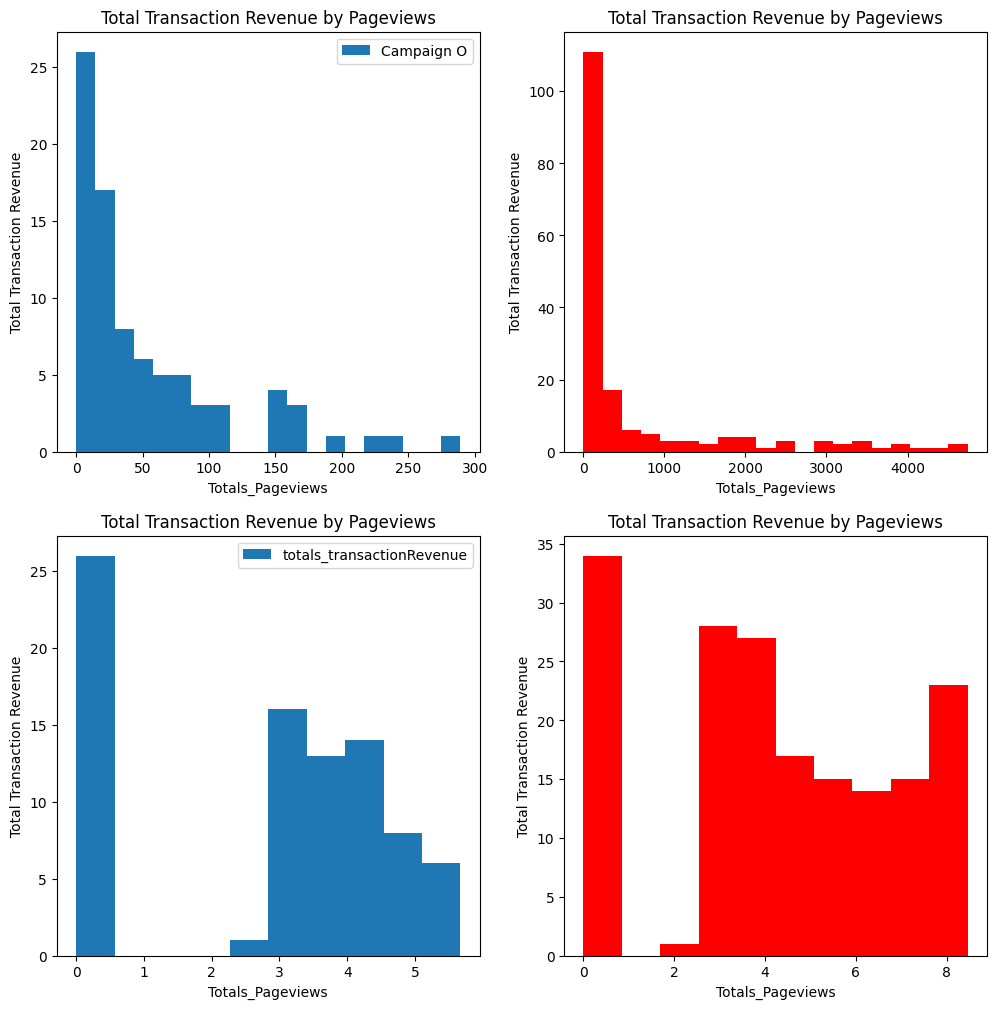

In [363]:
# 페이지뷰에 따른 거래 수익 비교, Not캠페인 그룹은 0이 너무 많아서 log변환을 해서 그래프를 한번 그려봄

page_revenue=df_set[df_set['totals_pageviews'] >= 0].groupby('totals_pageviews')['totals_transactionRevenue'].sum()
page_revenue_notset=df_not_set[df_not_set['totals_pageviews'] >= 0].groupby('totals_pageviews')['totals_transactionRevenue'].sum()


plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.hist(page_revenue, bins=20,label='Campaign O')  
plt.legend()
plt.ylabel('Total Transaction Revenue')  
plt.xlabel('Totals_Pageviews') 
plt.title('Total Transaction Revenue by Pageviews') 


plt.subplot(2,2,2)
# np.log1p(page_revenue_notset).plot(kind='hist')
plt.hist(page_revenue_notset, bins=20,color='red')  
plt.ylabel('Total Transaction Revenue')  
plt.xlabel('Totals_Pageviews') 
plt.title('Total Transaction Revenue by Pageviews') 



plt.subplot(2,2,3)
np.log1p(page_revenue).plot(kind='hist')
plt.legend()
plt.ylabel('Total Transaction Revenue')  
plt.xlabel('Totals_Pageviews') 
plt.title('Total Transaction Revenue by Pageviews') 



plt.subplot(2,2,4)
np.log1p(page_revenue_notset).plot(kind='hist',color='red')
# plt.hist(page_revenue_notset, bins=20,color='red')  
plt.ylabel('Total Transaction Revenue')  
plt.xlabel('Totals_Pageviews') 
plt.title('Total Transaction Revenue by Pageviews') 
plt.show()

### 캠페인별 구매 전환율

In [403]:
# df_nost_set : 캠페인 X 그룹
#  df_not_set['totals_transactionRevenue'].count() : 캠페인 X인 그룹들 중 구매수 
# df_not_set['fullVisitorId'].count() : 캠페인 X인 그룹의 유저 수 

df_not_set['totals_transactionRevenue'].count() / df['totals_transactionRevenue'].count()

display(f" 캠페인 X인 그룹들 중 구매수 : {df_not_set['totals_transactionRevenue'].count()} ")
display(f" 캠페인 X인 그룹의 유저 수: {df_not_set['fullVisitorId'].count()}")
display(f"NOT캠페인 그룹의 구매 전환율 : {df_not_set['totals_transactionRevenue'].count() / df_not_set['fullVisitorId'].count():.4f}%")

display('===================================================')

display(f" 캠페인 X인 그룹들 중 구매수 : {df_set['totals_transactionRevenue'].count()} ")
display(f" 캠페인 X인 그룹의 유저 수: {df_set['fullVisitorId'].count()}")
display(f"캠페인 그룹의 구매 전환율 : {df_set['totals_transactionRevenue'].count() / df_set['fullVisitorId'].count():.4f}%")

print('===================================================')
print(f" 전체 그룹들 중 구매수 : {df['totals_transactionRevenue'].count()} ")
print(f" 전체 그룹의 유저 수: {df['fullVisitorId'].count()}")
print(f" 전체 그룹의 구매 전환율 : {df['totals_transactionRevenue'].count() / df['fullVisitorId'].count():.4f}%")

' 캠페인 X인 그룹들 중 구매수 : 5466 '

' 캠페인 X인 그룹의 유저 수: 431148'

'NOT캠페인 그룹의 구매 전환율 : 0.0127%'

'==================================================='

' 캠페인 X인 그룹들 중 구매수 : 226 '

' 캠페인 X인 그룹의 유저 수: 18852'

'캠페인 그룹의 구매 전환율 : 0.0120%'

 전체 그룹들 중 구매수 : 5692 
 전체 그룹의 유저 수: 450000
 전체 그룹의 구매 전환율 : 0.0126%


### 페이지뷰별 매출 확인

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


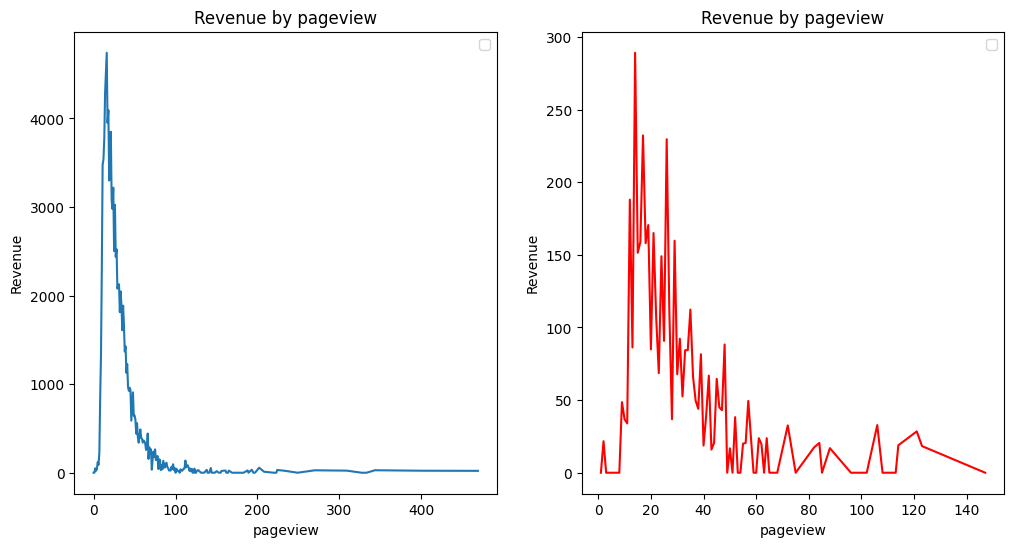

In [462]:
# revenue_set_page_counts=df_set.groupby('totals_pageviews')['totals_transactionRevenue'].count()


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
revenue_notset_page_counts =df_not_set.groupby('totals_pageviews')['totals_transactionRevenue'].sum()

plt.plot(revenue_notset_page_counts.index, revenue_notset_page_counts.values)
plt.title('Revenue by pageview')
plt.xlabel('pageview')
plt.ylabel('Revenue')
plt.legend()

plt.subplot(1,2,2)
revenue_set_page_counts = df_set.groupby('totals_pageviews')['totals_transactionRevenue'].sum()
plt.plot(revenue_set_page_counts.index, revenue_set_page_counts.values,color='red')
plt.title('Revenue by pageview')
plt.xlabel('pageview')
plt.ylabel('Revenue')
plt.legend()
plt.show()